In [1]:
from pyspark.sql import SparkSession
import numpy as np

spark = SparkSession.builder \
    .master("local") \
    .appName("Neural Network input_output") \
    .getOrCreate()

In [2]:
# load the dataset
data = spark.read.csv("GROUP2.csv.gz", header=True, sep=',',inferSchema="true")
data.dtypes

[('groupId', 'string'),
 ('matchId', 'string'),
 ('matchDuration', 'int'),
 ('winPlaceClass', 'int'),
 ('isFirstPerson', 'boolean'),
 ('matchtype', 'int'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('hasDisconnected', 'int'),
 ('assist_SUM', 'int'),
 ('assist_MAX', 'int'),
 ('assist_AVG', 'int'),
 ('heals_SUM', 'int'),
 ('heals_MAX', 'int'),
 ('heals_AVG', 'int'),
 ('kills_SUM', 'int'),
 ('kills_MAX', 'int'),
 ('kills_AVG', 'int'),
 ('headshotKills_SUM', 'int'),
 ('headshotKills_MAX', 'int'),
 ('headshotKills_AVG', 'int'),
 ('killStreaks_MAX', 'int'),
 ('roadKills_SUM', 'int'),
 ('roadKills_MAX', 'int'),
 ('roadKills_AVG', 'int'),
 ('longestKill_MAX', 'double'),
 ('vehicleDestroys_MAX', 'int'),
 ('weaponsAcquired_SUM', 'int'),
 ('weaponsAcquired_MAX', 'int'),
 ('weaponsAcquired_AVG', 'int'),
 ('damageDealt_SUM', 'double'),
 ('damageDealt_MAX', 'double'),
 ('damageDealt_AVG', 'double'),
 ('distance_SUM', 'double'),
 ('distance_MAX', 'double'),
 ('distance_AVG', 'double'),
 ('rideDis

In [3]:
from pyspark.sql.functions import col

data = data.withColumn("winPlaceClass", col("winPlaceClass") -1)

In [4]:
inputCols =  data.columns

toRemove = ['matchId', 'groupId', 'killPlace_MAX', 'rankPoints_MAX', 'killPoints_MAX', 'winPoints_MAX', 'winPlaceClass']
inputCols = list(set(inputCols) - set(toRemove))

In [5]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# winPlaceClass

assembler = VectorAssembler(
    inputCols=inputCols,
    outputCol="features")

output = assembler.transform(data)

In [6]:
from pyspark.ml.feature import StandardScaler


ss = StandardScaler()

ss.setInputCol("features")

model = ss.fit(output)

model.setOutputCol("features_scaled")

StandardScalerModel: uid=StandardScaler_109affb6b709, numFeatures=51, withMean=false, withStd=true

In [7]:
output_scaled = model.transform(output)

In [8]:
seed = 42
withReplacement=False
output_sample = output_scaled.sample(withReplacement, .3, seed).withColumnRenamed("winPlaceClass", "label").select("features_scaled", "label")

(training,testing) = output_sample.randomSplit([0.7,0.3])
print(F'training: {training.count()}')
print(F'testing: {testing.count()}')

training: 423437
testing: 181953


In [9]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [10]:
from pyspark.mllib.evaluation import MulticlassMetrics
import pandas as pd

def customEarlyStoppingNN(blockSize = 128, layers = [], training = None, iterazioni = 10, optimizerIt=5, es = 5):
    (training,validation) = output_sample.randomSplit([0.8,0.2])
    evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

    
    loss_train = []
    loss_val = []
    acc_train = []
    acc_val = []
    models = []
    best_model = 0;
    
    es_count = 0

    for i in range(iterazioni):
        
        trainer = MultilayerPerceptronClassifier(maxIter=optimizerIt, layers=layers, blockSize=blockSize, seed=42)

        if len(models) != 0:
            trainer = trainer.setInitialWeights(models[-1].weights)
        
        model = trainer.fit(training.withColumnRenamed( "features_scaled", "features"))
        
        models.append(model)
        
        trainStat = model.summary()
        
        result = model.transform(validation.withColumnRenamed( "features_scaled", "features"))
        
        evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", probabilityCol="probability")

        evaluator.setMetricName('logLoss')
        logLoss = evaluator.evaluate(result)
        evaluator.setMetricName('accuracy')
        accuracy = evaluator.evaluate(result)
        
        print(F'Epoch {i+1}*{optimizerIt}: loss: {trainStat.objectiveHistory[0]}, acc: {trainStat.accuracy}, val_loss: {logLoss}, val_acc: {accuracy}')
        
        
        if len(loss_val) != 0:
            if loss_val[best_model] < logLoss:
                es_count = es_count +1
            else:
                es_count = 0
                best_model = len(models)-1
            
        if es_count == es:
            print("Early Stopping")
            break
        
        loss_train.append(trainStat.objectiveHistory[0])
        acc_train.append(trainStat.accuracy)
        loss_val.append(logLoss)
        acc_val.append(accuracy)
    
    df = pd.DataFrame()
    
    df["loss_train"] = loss_train
    df["acc_train"] = acc_train
    df["loss_val"] = loss_val
    df["acc_val"] = acc_val
    
    
    return (df, models[best_model])

In [11]:
%%time
df_risultati, model = customEarlyStoppingNN(blockSize = 200, layers = [51, 6], training = training, iterazioni = 200, optimizerIt=5, es = 5)

Epoch 1*5: loss: 4.438972208875058, acc: 0.47255912361101354, val_loss: 1.5029441412963505, val_acc: 0.4738970709367072
Epoch 2*5: loss: 1.5084340077350888, acc: 0.5659564532858389, val_loss: 1.1005129925914032, val_acc: 0.5692481302098777
Epoch 3*5: loss: 1.106303059352449, acc: 0.5995917237275459, val_loss: 1.0244162228944012, val_acc: 0.6016440973938256
Epoch 4*5: loss: 1.0305018628464309, acc: 0.619048898108623, val_loss: 0.9655203056491244, val_acc: 0.6210997990181543
Epoch 5*5: loss: 0.9697041791295916, acc: 0.6379337418850959, val_loss: 0.9294264244817553, val_acc: 0.640646107212283
Epoch 6*5: loss: 0.9344913981911522, acc: 0.6415040930936019, val_loss: 0.9037855766679576, val_acc: 0.6445504266745742
Epoch 7*5: loss: 0.9080921607358172, acc: 0.6567855268540825, val_loss: 0.8691284603158097, val_acc: 0.6596817238311753
Epoch 8*5: loss: 0.8738130574073224, acc: 0.6610583777216696, val_loss: 0.8519914085051349, val_acc: 0.6649863266449211
Epoch 9*5: loss: 0.8562255998923924, acc: 0

Epoch 70*5: loss: 0.6989995981197177, acc: 0.7122251470083846, val_loss: 0.6932511415348475, val_acc: 0.7155695034759975
Epoch 71*5: loss: 0.698755906586661, acc: 0.7121404338142012, val_loss: 0.6929982520074184, val_acc: 0.7158166123027248
Epoch 72*5: loss: 0.6984984130738634, acc: 0.7123305219572467, val_loss: 0.6927759112318082, val_acc: 0.7156683470066885
Epoch 73*5: loss: 0.6982757482941765, acc: 0.7121920882008984, val_loss: 0.6924834968556148, val_acc: 0.7158413231853975
Epoch 74*5: loss: 0.6979848190290655, acc: 0.7125185439248243, val_loss: 0.6922687757154665, val_acc: 0.7158660340680703
Epoch 75*5: loss: 0.6977623170351166, acc: 0.7123573822383292, val_loss: 0.6918946871234596, val_acc: 0.7159319297551975
Epoch 76*5: loss: 0.6973951367697171, acc: 0.7126280512246222, val_loss: 0.6916482804835171, val_acc: 0.7160225363249976
Epoch 77*5: loss: 0.6971383375888675, acc: 0.7124420954325125, val_loss: 0.6913036909621871, val_acc: 0.716071958090343
Epoch 78*5: loss: 0.69679616946543

Epoch 138*5: loss: 0.6816666860723217, acc: 0.7165124611042468, val_loss: 0.6762026133527252, val_acc: 0.7204210734407434
Epoch 139*5: loss: 0.6815700204059804, acc: 0.7164938655250358, val_loss: 0.6761351861759509, val_acc: 0.7204128364798524
Epoch 140*5: loss: 0.6814777972376604, acc: 0.7165785787192192, val_loss: 0.6760535986673734, val_acc: 0.7205116800105433
Epoch 141*5: loss: 0.6814114012169475, acc: 0.7164856008231643, val_loss: 0.6759633205251934, val_acc: 0.7205940496194524
Epoch 142*5: loss: 0.6813082016933143, acc: 0.7166467625096594, val_loss: 0.6758731488309073, val_acc: 0.7206599453065797
Epoch 143*5: loss: 0.6812341891121868, acc: 0.7166508948605952, val_loss: 0.6758065428557148, val_acc: 0.7205611017758887
Epoch 144*5: loss: 0.6811472867259322, acc: 0.7166880860190171, val_loss: 0.6757280884076303, val_acc: 0.7206434713847979
Epoch 145*5: loss: 0.6810833932743502, acc: 0.7166302331059163, val_loss: 0.6756466809663622, val_acc: 0.7206434713847979
Epoch 146*5: loss: 0.680

In [12]:
df_risultati

,loss_train,acc_train,loss_val,acc_val
0,4.438972,0.472559,1.502944,0.473897
1,1.508434,0.565956,1.100513,0.569248
2,1.106303,0.599592,1.024416,0.601644
3,1.030502,0.619049,0.965520,0.621100
4,0.969704,0.637934,0.929426,0.640646
...,...,...,...,...
195,0.675640,0.718874,0.670350,0.722464
196,0.675616,0.718843,0.670330,0.722554
197,0.675572,0.718856,0.670280,0.722423
198,0.675540,0.718998,0.670268,0.722571


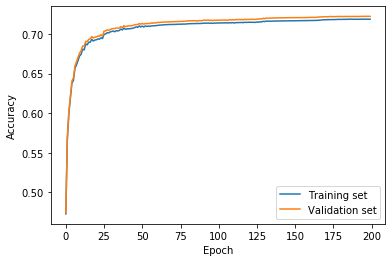

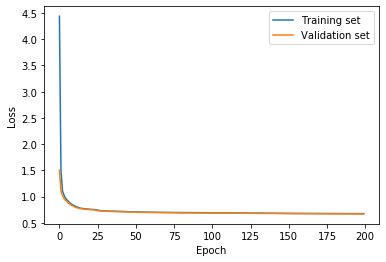

In [13]:
import matplotlib.pyplot as plt

df = pd.DataFrame()

plt.plot(df_risultati["acc_train"], label="Training set")
plt.plot(df_risultati["acc_val"], label="Validation set")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("Accuracy_NN_io.pdf")
plt.show()


plt.plot(df_risultati["loss_train"], label="Training set")
plt.plot(df_risultati["loss_val"], label="Validation set")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.savefig("Loss_NN_io.pdf")
plt.show()

In [14]:
model.weights

DenseVector([0.0749, 0.0798, 0.0765, 0.0682, 0.1582, -0.1806, 0.1069, 0.1696, 0.1484, 0.1092, 0.0604, 0.0525, 0.125, 0.0274, 0.0284, -0.0267, -0.0623, 0.1242, 0.1296, 0.0158, 0.0373, 0.0229, 0.0376, 0.134, 0.06, 0.413, 0.3683, -0.0881, -0.1733, -0.5902, 0.0965, 0.0343, 0.0865, 0.1211, 0.2235, 0.0939, -0.1122, -0.0871, -0.0636, -0.0125, -0.0757, -0.1305, 2.2409, 1.7736, 1.61, 0.1054, -2.669, -1.8707, -0.1433, -0.0104, 0.1544, 0.2713, 0.2797, -0.5078, -0.3459, -0.8897, 0.1665, 0.5891, 0.5592, -0.0829, 0.6075, 0.0033, 0.1154, 0.5969, 0.463, -1.7238, 0.8662, 0.0724, -0.07, -0.1869, -0.4077, -0.3901, 0.1262, 0.1887, 0.2137, 0.0289, -0.1989, -0.2745, 1.0662, 1.1011, 0.9505, 0.4079, -0.9207, -2.862, -0.3777, -0.1784, -0.1623, -0.0878, -0.0547, 0.1004, -0.232, -0.069, 0.0182, 0.0286, 0.0331, -0.0749, -0.2756, -0.0906, -0.0096, 0.0317, 0.1065, -0.0984, -0.6048, -0.4774, -0.4055, -0.2168, 1.1176, -0.0781, -1.5769, -1.2908, -0.3758, 0.5789, 1.1915, 1.1602, 0.6464, 0.575, 0.4582, 0.255, -0.1899, -

In [15]:
model.weights.shape

(312,)

In [16]:
312/6 #numero di pesi per ogni nodo dell'output layer

52.0

In [17]:
model.weights[:51]

array([ 0.07486479,  0.07982522,  0.07649755,  0.06823164,  0.15824293,
       -0.18063492,  0.10689138,  0.1695808 ,  0.14842116,  0.10922709,
        0.06036082,  0.0524647 ,  0.12501854,  0.02740781,  0.02838439,
       -0.02672199, -0.06226685,  0.12417397,  0.12964254,  0.01577964,
        0.03728779,  0.02286208,  0.0375921 ,  0.13398843,  0.05997193,
        0.41300157,  0.36832595, -0.08812631, -0.17334985, -0.590231  ,
        0.09649009,  0.03432093,  0.08648939,  0.12105055,  0.22353766,
        0.09393969, -0.11217705, -0.08705427, -0.06362091, -0.01249173,
       -0.07570302, -0.13049632,  2.24094811,  1.77362726,  1.60996285,
        0.10543873, -2.66895332, -1.87070434, -0.14329964, -0.01035145,
        0.1544339 ])

CLASSE  1
range 0   51


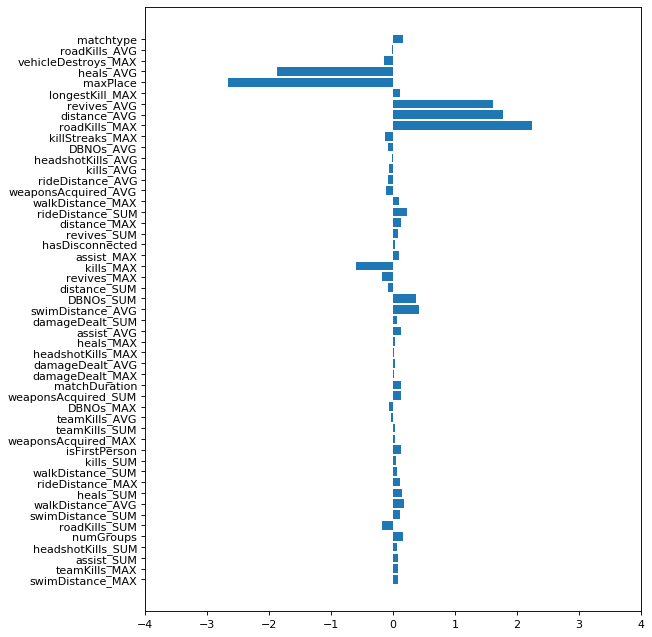

CLASSE  2
range 52   103


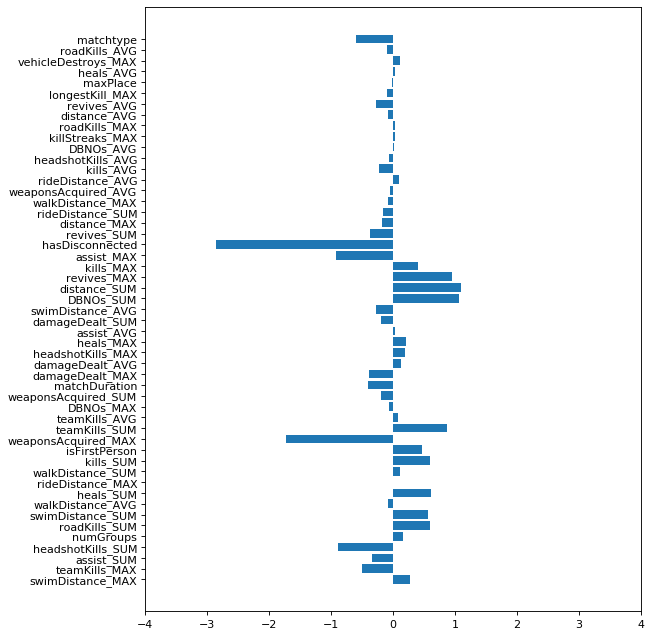

CLASSE  3
range 104   155


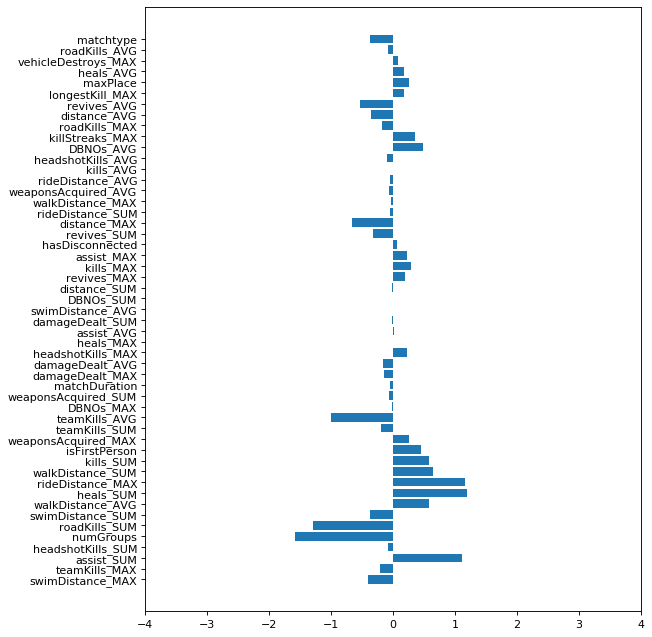

CLASSE  4
range 156   207


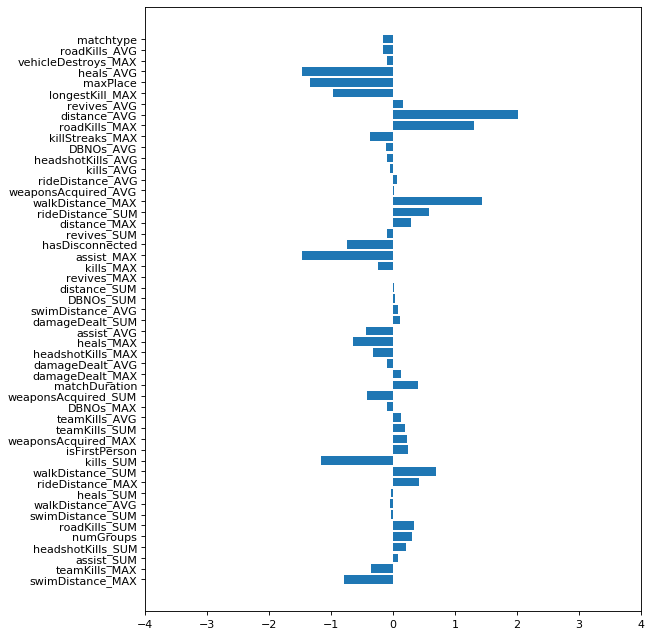

CLASSE  5
range 208   259


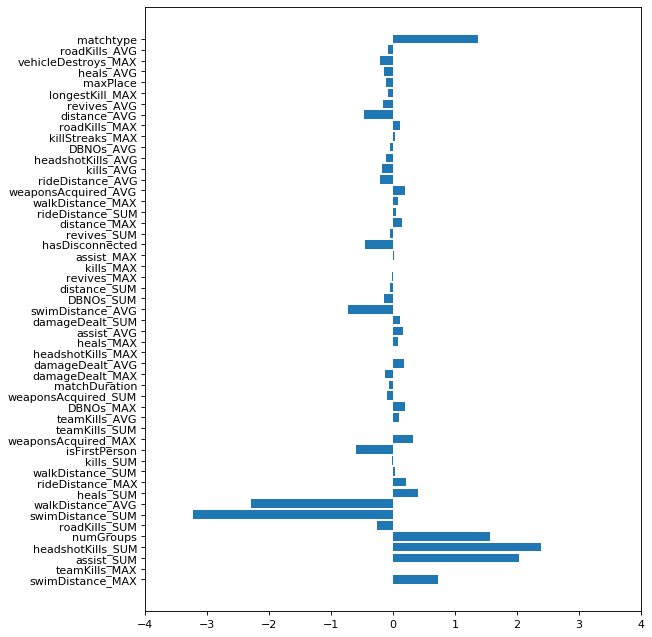

CLASSE  6
range 260   311


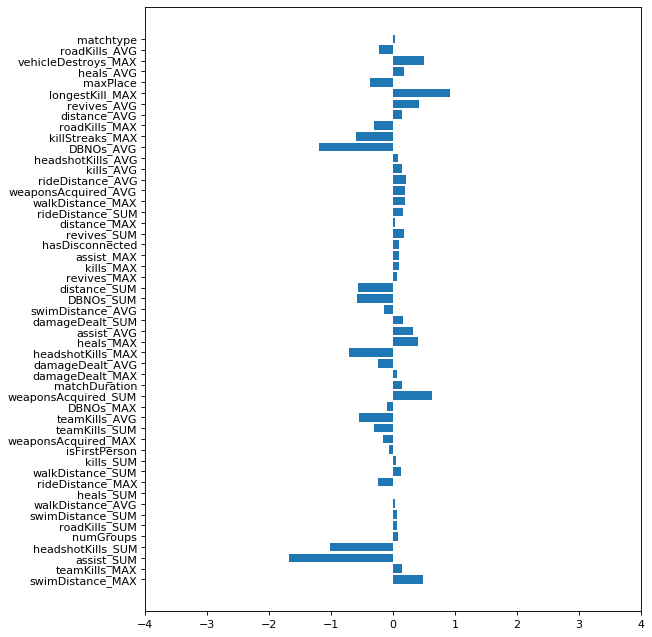

In [18]:
from matplotlib.pyplot import figure

for i in range(1, 7):
    print("CLASSE ", i)
    print("range", (i-1)*52, " ", (i*52-1))
    figure(figsize=(8, 10), dpi=80)
    #plt.barh(inputCols, list(map(lambda x: abs(x), model.weights[(i-1)*37:(i*37-1)])))
    plt.barh(inputCols, model.weights[(i-1)*52:(i*52-1)])
    plt.xlim([-4, 4])
    plt.show()

In [19]:
df_perVar = pd.DataFrame()

tmp = []

for i in range(1, 7):
    df_perVar[F'Classe_{i}'] = model.weights[(i-1)*52:(i*52-1)]
    tmp.append(model.weights[(i-1)*52:(i*52-1)])

In [20]:
df_perVar = pd.DataFrame(tmp, columns=inputCols) 

In [21]:
df_perVar

,swimDistance_MAX,teamKills_MAX,assist_SUM,headshotKills_SUM,numGroups,roadKills_SUM,swimDistance_SUM,walkDistance_AVG,heals_SUM,rideDistance_MAX,...,killStreaks_MAX,roadKills_MAX,distance_AVG,revives_AVG,longestKill_MAX,maxPlace,heals_AVG,vehicleDestroys_MAX,roadKills_AVG,matchtype
0,0.074865,0.079825,0.076498,0.068232,0.158243,-0.180635,0.106891,0.169581,0.148421,0.109227,...,-0.130496,2.240948,1.773627,1.609963,0.105439,-2.668953,-1.870704,-0.143300,-0.010351,0.154434
1,0.279730,-0.507750,-0.345902,-0.889698,0.166502,0.589143,0.559230,-0.082931,0.607457,0.003278,...,0.028564,0.033067,-0.074854,-0.275574,-0.090649,-0.009600,0.031683,0.106454,-0.098438,-0.604808
2,-0.405478,-0.216785,1.117583,-0.078056,-1.576948,-1.290838,-0.375798,0.578922,1.191545,1.160202,...,0.347814,-0.176756,-0.357355,-0.528116,0.175832,0.252852,0.179472,0.079410,-0.073201,-0.377047
3,-0.797964,-0.352433,0.075354,0.215323,0.311672,0.335068,-0.038339,-0.047277,-0.030912,0.418269,...,-0.363702,1.309173,2.021394,0.166366,-0.969698,-1.346523,-1.468425,-0.103362,-0.169554,-0.153808
4,0.731406,0.006542,2.031143,2.383086,1.559569,-0.266358,-3.228155,-2.296665,0.399214,0.212856,...,0.026414,0.106936,-0.468747,-0.153885,-0.081533,-0.110342,-0.138806,-0.203511,-0.077574,1.371643
5,0.484582,0.147253,-1.682455,-1.016569,0.080336,0.068169,0.072000,0.039544,-0.002678,-0.235753,...,-0.602587,-0.299174,0.150029,0.425830,0.911414,-0.367353,0.184744,0.495478,-0.221207,0.027155


In [22]:
df_perVar.describe()

,swimDistance_MAX,teamKills_MAX,assist_SUM,headshotKills_SUM,numGroups,roadKills_SUM,swimDistance_SUM,walkDistance_AVG,heals_SUM,rideDistance_MAX,...,killStreaks_MAX,roadKills_MAX,distance_AVG,revives_AVG,longestKill_MAX,maxPlace,heals_AVG,vehicleDestroys_MAX,roadKills_AVG,matchtype
count,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
mean,0.061190,-0.140558,0.212037,0.113720,0.116562,-0.124242,-0.484028,-0.273138,0.385508,0.278013,...,-0.115666,0.535699,0.507349,0.207431,0.008467,-0.708320,-0.513673,0.038528,-0.108388,0.069595
std,0.571371,0.260221,1.270166,1.223404,0.999386,0.654405,1.377485,1.019964,0.464639,0.483756,...,0.333058,1.014615,1.101173,0.764376,0.604559,1.107906,0.912059,0.255682,0.075322,0.694053
min,-0.797964,-0.507750,-1.682455,-1.016569,-1.576948,-1.290838,-3.228155,-2.296665,-0.030912,-0.235753,...,-0.602587,-0.299174,-0.468747,-0.528116,-0.969698,-2.668953,-1.870704,-0.203511,-0.221207,-0.604808
25%,-0.285393,-0.318521,-0.240588,-0.686787,0.099813,-0.244928,-0.291433,-0.074018,0.035097,0.029765,...,-0.305401,-0.124301,-0.286730,-0.245152,-0.088370,-1.101730,-1.136021,-0.133315,-0.151775,-0.321238
50%,0.177297,-0.105121,0.075926,-0.004912,0.162372,-0.056233,0.016831,-0.003866,0.273817,0.161042,...,-0.052041,0.070001,0.037588,0.006241,0.011953,-0.238847,-0.053561,-0.011976,-0.088006,-0.063326
75%,0.433369,0.061504,0.857312,0.178550,0.275380,0.268344,0.098169,0.137072,0.555396,0.366916,...,0.028027,1.008614,1.367728,0.360964,0.158234,-0.034785,0.142525,0.099693,-0.074294,0.122614
max,0.731406,0.147253,2.031143,2.383086,1.559569,0.589143,0.559230,0.578922,1.191545,1.160202,...,0.347814,2.240948,2.021394,1.609963,0.911414,0.252852,0.184744,0.495478,-0.010351,1.371643


In [23]:
df_perVar.describe().iloc[2]

swimDistance_MAX       0.571371
teamKills_MAX          0.260221
assist_SUM             1.270166
headshotKills_SUM      1.223404
numGroups              0.999386
roadKills_SUM          0.654405
swimDistance_SUM       1.377485
walkDistance_AVG       1.019964
heals_SUM              0.464639
rideDistance_MAX       0.483756
walkDistance_SUM       0.305271
kills_SUM              0.637637
isFirstPerson          0.396762
weaponsAcquired_MAX    0.777551
teamKills_SUM          0.415286
teamKills_AVG          0.462544
DBNOs_MAX              0.112875
weaponsAcquired_SUM    0.357281
matchDuration          0.272300
damageDealt_MAX        0.187972
damageDealt_AVG        0.164544
headshotKills_MAX      0.355261
heals_MAX              0.354550
assist_AVG             0.259173
damageDealt_SUM        0.132107
swimDistance_AVG       0.381464
DBNOs_SUM              0.555886
distance_SUM           0.549788
revives_MAX            0.399862
kills_MAX              0.366258
assist_MAX             0.696694
hasDisco

In [24]:
std = df_perVar.describe().iloc[2]

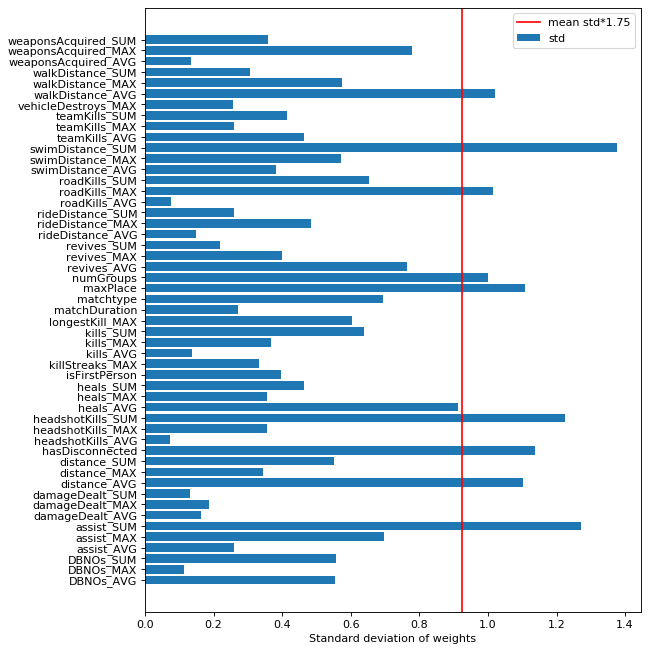

In [25]:
figure(figsize=(8, 10), dpi=80)

inputCols.sort()
std = std.sort_index()

plt.barh(std.index, std.values, label="std")

std_mean = 0

for i in std: std_mean +=i

plt.axvline(x=std_mean/len(std)*1.75, c='r', label="mean std*1.75")

plt.xlabel("Standard deviation of weights")
plt.legend()

plt.savefig("std_NN_io.pdf", bbox='tight')

<BarContainer object of 51 artists>

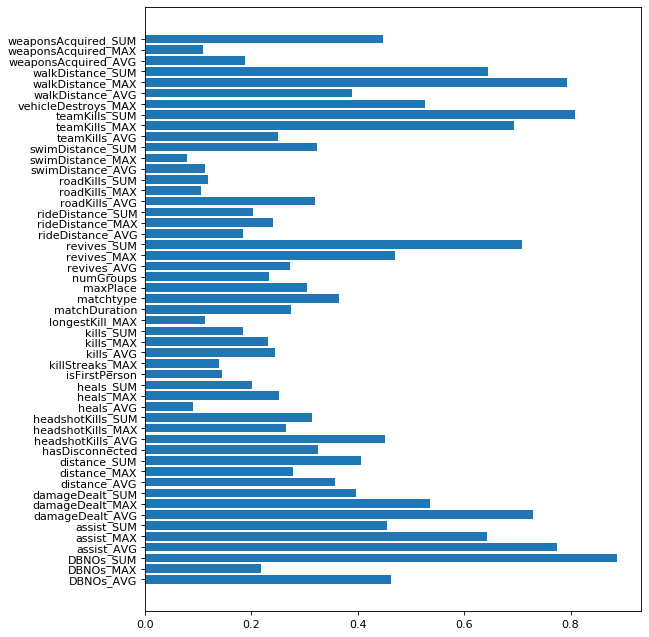

In [26]:
mean = df_perVar.abs().describe().iloc[1]

figure(figsize=(8, 10), dpi=80)

plt.barh(inputCols, mean)

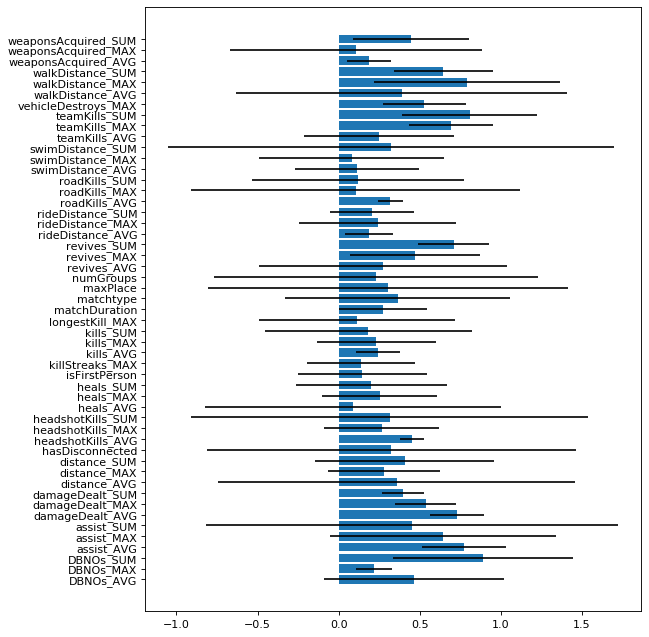

In [29]:
figure(figsize=(8, 10), dpi=80)
#plt.barh(inputCols, std)
plt.barh(inputCols, mean, xerr=np.array(std))

plt.savefig("mean and std_NN_io.pdf")

In [30]:
predictions = model.transform(testing.withColumnRenamed( "features_scaled", "features"))
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(51,[0,1,2,3,4,6,...|    2|[-0.3217121564818...|[0.00242718121746...|       2.0|
|(51,[0,1,2,4,6,7,...|    2|[-4.2300069946184...|[2.65799825811635...|       2.0|
|(51,[0,1,2,4,6,7,...|    3|[-11.100176484227...|[5.05990999518757...|       3.0|
|(51,[0,1,2,4,6,7,...|    3|[-7.0422637094733...|[3.24348210716718...|       3.0|
|(51,[0,1,2,4,6,7,...|    3|[-2.0700483973340...|[1.99159669922271...|       2.0|
|(51,[0,1,2,4,6,7,...|    3|[-0.5178231905435...|[4.26866260126186...|       2.0|
|(51,[0,1,2,4,6,7,...|    2|[-5.4003657758376...|[1.36278985359848...|       3.0|
|(51,[0,1,2,4,6,7,...|    1|[7.44333176396488...|[0.00722539100380...|       1.0|
|(51,[0,1,2,4,6,7,...|    4|[-9.8748025445600...|[5.55337345639879...|       4.0|
|(51,[0,1,2,4,6,

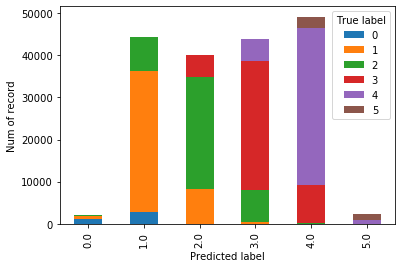

In [31]:
cross_tab = predictions.crosstab('prediction', 'label').toPandas().sort_values(by=["prediction_label"]).set_index('prediction_label')
cross_tab.plot.bar(stacked=True)

plt.ylabel("Num of record")
plt.xlabel("Predicted label")
plt.legend(title="True label")

plt.savefig("confMatrixGraph_NN_io.pdf")

In [32]:
model.write().overwrite().save("NN.input_output")

## Evaluation

In [33]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels_prob = predictions.rdd.map(lambda x: (x.prediction, float(x.label)))
metrics = MulticlassMetrics(predictionAndLabels_prob)

In [34]:
# Summary stats
print("Recall = %s" % metrics.weightedRecall)
print("Precision = %s" % metrics.weightedPrecision)
print("F1 measure = %s" % metrics.weightedFMeasure())
print("Accuracy = %s" % metrics.accuracy)

# Individual label stats
labels = [0.0, 1.0, 2.0 ,3.0, 4.0, 5.0]
for label in labels:
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label)))
    
print('Confusion Matrix')
print(metrics.confusionMatrix().toArray())

Recall = 0.7187570416536138
Precision = 0.7142110727230633
F1 measure = 0.7133106026671345
Accuracy = 0.7187570416536139
Class 0.0 precision = 0.6258847320525783
Class 0.0 recall = 0.29773929773929775
Class 0.0 F1 Measure = 0.40352020860495436
Class 1.0 precision = 0.7538603520460991
Class 1.0 recall = 0.7862659936612278
Class 1.0 F1 Measure = 0.7697222509509198
Class 2.0 precision = 0.6656869582544584
Class 2.0 recall = 0.6280490670677257
Class 2.0 F1 Measure = 0.6463205242920363
Class 3.0 precision = 0.6998425987179779
Class 3.0 recall = 0.6810744810744811
Class 3.0 F1 Measure = 0.6903310006525505
Class 4.0 precision = 0.7561918717056393
Class 4.0 recall = 0.8573175515101175
Class 4.0 F1 Measure = 0.803585717684206
Class 5.0 precision = 0.6135146271116605
Class 5.0 recall = 0.3495305164319249
Class 5.0 F1 Measure = 0.4453417077912367
Confusion Matrix
[[1.2380e+03 2.8150e+03 7.1000e+01 2.5000e+01 4.0000e+00 5.0000e+00]
 [7.1800e+02 3.3491e+04 8.0840e+03 2.8500e+02 1.6000e+01 1.0000e+0

## Sklearn metrics

In [35]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [36]:
from sklearn.metrics import classification_report, confusion_matrix

In [37]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.30      0.40      4158
           1       0.75      0.79      0.77     42595
           2       0.67      0.63      0.65     42554
           3       0.70      0.68      0.69     45045
           4       0.76      0.86      0.80     43341
           5       0.61      0.35      0.45      4260

    accuracy                           0.72    181953
   macro avg       0.69      0.60      0.63    181953
weighted avg       0.71      0.72      0.71    181953



In [38]:
print(confusion_matrix(y_true, y_pred))

[[ 1238  2815    71    25     4     5]
 [  718 33491  8084   285    16     1]
 [   18  8006 26726  7599   195    10]
 [    2   112  5231 30679  9004    17]
 [    0     0    34  5245 37157   905]
 [    2     2     2     4  2761  1489]]
